<a href="https://colab.research.google.com/gist/hafizfarhad/0ba95d685513a4134f59f910f8e46646/nids_using_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Intrusion Detection System (NIDS) using Machine Learning

## Project Overview

This notebook implements a real-time Network Intrusion Detection System (NIDS) that uses machine learning to detect potential intrusions in network traffic. The system captures network packets, extracts relevant features, and classifies them as normal or anomalous using a trained neural network model.

### Key Components:

1. **Data Collection & Preprocessing**: Uses the NSL-KDD dataset, a standard benchmark for network intrusion detection
2. **Feature Engineering**: Extracts and processes relevant features from network packets
3. **Model Training**: Builds and trains a neural network using TensorFlow/Keras
4. **Real-time Detection**: Captures and analyzes live network traffic using Scapy
5. **Visualization & Analysis**: Provides comprehensive visualizations and performance metrics


### Technologies Used:
- Scapy for packet capture
- TensorFlow and Keras for ML models
- Pandas and NumPy for data processing
- Matplotlib and Seaborn for visualization

## step 01

Let's set up the necessary libraries and package

In [ ]:
# Install necessary packages if not already installed
# Uncomment the line below to install all required packages
# !pip uninstall -y tensorflow tensorflow-estimator keras
# !pip install --upgrade pip
!pip install tensorflow==2.12.0
!pip install scapy
# !pip install --upgrade https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-0.12.0-py3-none-any.whl # pip install
!pip install keras pandas numpy scikit-learn matplotlib seaborn joblib netifaces requests

In [ ]:
# Import required libraries with error handling
import sys
try:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    from sklearn.metrics import (
        classification_report, confusion_matrix, roc_curve, auc,
        precision_recall_curve, average_precision_score, f1_score
    )
    from scapy.all import *
    import time
    import warnings
    import requests
    import io
    import joblib
    import os
    warnings.filterwarnings('ignore')

    print("Libraries imported successfully!")
except ImportError as e:
    print(f"Error importing libraries: {e}")
    print("Please run the pip install command above to install all required packages.")

Libraries imported successfully!


## step 02

Using the NSL-KDD dataset, which is commonly used for network intrusion detection research.

In [ ]:
# Download the NSL-KDD dataset
# Uncomment the lines below if you need to download the dataset
# !wget https://www.unb.ca/cic/datasets/nsl.html -O nsl-kdd.zip
# !unzip nsl-kdd.zip

# For this implementation, we'll use a direct download link to the CSV file
# You can replace this with the actual file path if you have the dataset locally
import requests
import io

def download_nsl_kdd():
    try:
        # Try to load from local path first
        try:
            train_data = pd.read_csv('KDDTrain+.txt')
            test_data = pd.read_csv('KDDTest+.txt')
            print("Local dataset files loaded successfully!")
            return train_data, test_data
        except:
            print("Local dataset files not found. Downloading from online source...")

        # If not available locally, download from an online source
        train_url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.txt"
        test_url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.txt"

        train_response = requests.get(train_url)
        test_response = requests.get(test_url)

        # Check if the download was successful
        if train_response.status_code == 200 and test_response.status_code == 200:
            # Define column names according to NSL-KDD dataset documentation
            col_names = [
                'duration', 'protocol_type', 'service', 'flag', 'src_bytes',
                'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
                'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
                'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
                'num_access_files', 'num_outbound_cmds', 'is_host_login',
                'is_guest_login', 'count', 'srv_count', 'serror_rate',
                'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
                'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
                'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
                'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
                'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
                'dst_host_srv_rerror_rate', 'label', 'difficulty_level'
            ]

            # Convert the content to pandas DataFrames
            train_data = pd.read_csv(io.StringIO(train_response.text), header=None, names=col_names)
            test_data = pd.read_csv(io.StringIO(test_response.text), header=None, names=col_names)

            print("Dataset downloaded successfully!")
            return train_data, test_data
        else:
            print("Failed to download the dataset. Please check your internet connection.")
            return None, None
    except Exception as e:
        print(f"Error downloading dataset: {e}")
        return None, None

# Download the NSL-KDD dataset
train_data, test_data = download_nsl_kdd()

# Display the first few rows of the training dataset
if train_data is not None:
    print("\nTraining dataset shape:", train_data.shape)
    print("\nSample of training data:")
    print(train_data.head())

    # Count of attack types in the training dataset
    print("\nDistribution of attack types in training dataset:")
    print(train_data['label'].value_counts())

Local dataset files not found. Downloading from online source...
Dataset downloaded successfully!

Training dataset shape: (125973, 43)

Sample of training data:
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.17   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.10   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    1.00   

   dst_host_diff_srv_rate 

## step 03

Let's preprocess the data and extract relevant features.

In [ ]:
def preprocess_data(train_data, test_data):
    # Making a copy of the original data
    train_df = train_data.copy()
    test_df = test_data.copy()

    # Drop the difficulty_level column as it's not needed for classification
    train_df.drop('difficulty_level', axis=1, inplace=True)
    test_df.drop('difficulty_level', axis=1, inplace=True)

    # Convert attack labels to binary classification (normal vs attack)
    train_df['binary_label'] = train_df['label'].apply(lambda x: 0 if x == 'normal' else 1)
    test_df['binary_label'] = test_df['label'].apply(lambda x: 0 if x == 'normal' else 1)

    # Handle categorical features using one-hot encoding
    categorical_cols = ['protocol_type', 'service', 'flag']
    train_categorical = pd.get_dummies(train_df[categorical_cols], drop_first=True)
    test_categorical = pd.get_dummies(test_df[categorical_cols], drop_first=True)

    # Ensure test data has the same columns as train data
    missing_cols = set(train_categorical.columns) - set(test_categorical.columns)
    for col in missing_cols:
        test_categorical[col] = 0
    test_categorical = test_categorical[train_categorical.columns]

    # Drop the original categorical columns and the non-binary label
    train_df = train_df.drop(categorical_cols + ['label'], axis=1)
    test_df = test_df.drop(categorical_cols + ['label'], axis=1)

    # Combine the numerical and one-hot encoded categorical features
    train_df = pd.concat([train_df, train_categorical], axis=1)
    test_df = pd.concat([test_df, test_categorical], axis=1)

    # Separate features and target
    X_train = train_df.drop('binary_label', axis=1)
    y_train = train_df['binary_label']
    X_test = test_df.drop('binary_label', axis=1)
    y_test = test_df['binary_label']

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, y_train, X_test_scaled, y_test, scaler

# Preprocess the data
if train_data is not None and test_data is not None:
    X_train, y_train, X_test, y_test, scaler = preprocess_data(train_data, test_data)
    print("Data preprocessing completed!")
    print(f"Training data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")

    # Check class distribution
    print("\nClass distribution in training set:")
    print(pd.Series(y_train).value_counts(normalize=True) * 100)

    # Check class distribution in test set
    print("\nClass distribution in test set:")
    print(pd.Series(y_test).value_counts(normalize=True) * 100)

Data preprocessing completed!
Training data shape: (125973, 119)
Testing data shape: (22544, 119)

Class distribution in training set:
binary_label
0    53.458281
1    46.541719
Name: proportion, dtype: float64

Class distribution in test set:
binary_label
1    56.924237
0    43.075763
Name: proportion, dtype: float64


## step 04

Now, let's build and train our ML model.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                7680      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 10,305
Trainable params: 10,305
Non-traina

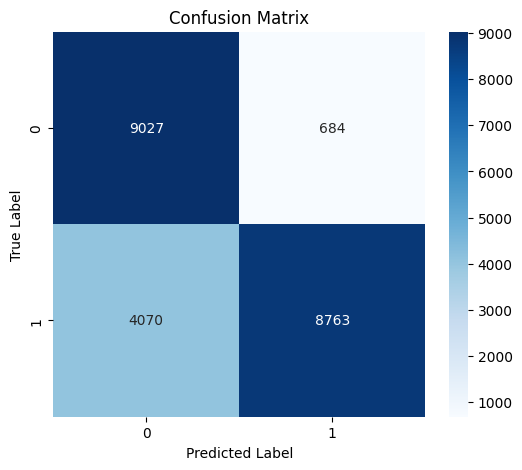

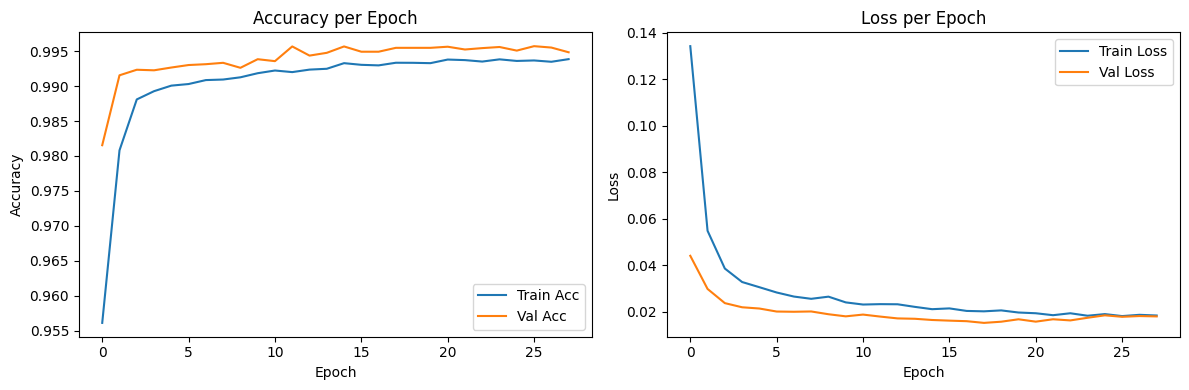

Model saved to 'nids_model.h5'


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix

def build_model(input_shape):
    """
    Build a neural network model for binary classification of network traffic
    """
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dropout(0.5),  # Dropout for regularization
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification output
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_model(X_train, y_train, X_test, y_test):
    """
    Train the neural network model
    """
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # Build the model
    model = build_model(X_train.shape[1])
    model.summary()

    # Train
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=128,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest Loss: {test_loss:.4f} — Test Accuracy: {test_accuracy:.4f}")

    # Predictions and metrics
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Training history plots
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

if __name__ == '__main__':
    # Make sure X_train, y_train, X_test, y_test are defined and preprocessed
    nids_model = train_model(X_train, y_train, X_test, y_test)
    nids_model.save('nids_model.h5')
    print("Model saved to 'nids_model.h5'")

## step 05

Let's implement the real-time packet capture and detection system.

In [ ]:
class NIDSPacketCapture:
    def __init__(self, model_path='nids_model.h5', scaler=None, interface='eth0'):
        """
        Initialize the NIDS packet capture system

        Parameters:
        -----------
        model_path : str
            Path to the saved model file
        scaler : StandardScaler
            Scaler used to normalize features
        interface : str
            Network interface to capture packets from
        """
        self.model = tf.keras.models.load_model(model_path)
        self.scaler = scaler
        self.interface = interface
        self.packet_buffer = []
        self.buffer_size = 100  # Number of packets to buffer before analysis
        self.alert_threshold = 0.7  # Probability threshold for alerts

    def extract_features_from_packet(self, packet):
        """
        Extract relevant features from a captured packet

        Parameters:
        -----------
        packet : Scapy packet
            Captured network packet

        Returns:
        --------
        dict : Dictionary containing extracted features
        """
        features = {
            # Initialize with default values
            'duration': 0,
            'protocol_type': 'tcp',  # Default protocol
            'service': 'http',       # Default service
            'flag': 'SF',            # Default flag
            'src_bytes': 0,
            'dst_bytes': 0,
            'land': 0,
            'wrong_fragment': 0,
            'urgent': 0,
            # Additional features with default values
            'count': 1,
            'srv_count': 1,
            'serror_rate': 0,
            'srv_serror_rate': 0,
            'rerror_rate': 0,
            'srv_rerror_rate': 0,
            'same_srv_rate': 1,
            'diff_srv_rate': 0,
            'srv_diff_host_rate': 0
        }

        # Extract IP layer features if present
        if IP in packet:
            features['src_bytes'] = len(packet[IP])

            # Check for TCP protocol
            if TCP in packet:
                features['protocol_type'] = 'tcp'
                # TCP flags can be used to identify connection state
                if packet[TCP].flags & 0x02:  # SYN flag
                    features['flag'] = 'S'
                elif packet[TCP].flags & 0x10:  # ACK flag
                    features['flag'] = 'A'

                # Identify service based on port
                dst_port = packet[TCP].dport
                if dst_port == 80:
                    features['service'] = 'http'
                elif dst_port == 443:
                    features['service'] = 'https'
                elif dst_port == 22:
                    features['service'] = 'ssh'
                elif dst_port == 21:
                    features['service'] = 'ftp'
                else:
                    features['service'] = 'other'

                # Check for urgent pointer
                features['urgent'] = 1 if packet[TCP].urgptr > 0 else 0

            # Check for UDP protocol
            elif UDP in packet:
                features['protocol_type'] = 'udp'
                features['flag'] = 'SF'  # No flags in UDP

                # Identify service based on port
                dst_port = packet[UDP].dport
                if dst_port == 53:
                    features['service'] = 'domain'
                else:
                    features['service'] = 'other'

            # Check for ICMP protocol
            elif ICMP in packet:
                features['protocol_type'] = 'icmp'
                features['flag'] = 'SF'  # No flags in ICMP
                features['service'] = 'ecr_i'  # echo reply

            # Check for fragment
            if packet[IP].flags & 0x01 or packet[IP].frag > 0:  # MF flag or fragment offset
                features['wrong_fragment'] = 1

            # Check for land attack (same source and destination)
            if packet[IP].src == packet[IP].dst:
                features['land'] = 1

            # Set destination bytes
            features['dst_bytes'] = features['src_bytes']  # Simplified assumption

        return features

    def preprocess_packet_features(self, packet_features):
        """
        Preprocess packet features to match the format expected by the model

        Parameters:
        -----------
        packet_features : dict
            Dictionary containing packet features

        Returns:
        --------
        np.array : Preprocessed features ready for model input
        """
        # Convert categorical features to one-hot encoding
        # Create a DataFrame with the features
        feature_df = pd.DataFrame([packet_features])

        # One-hot encode categorical features
        categorical_cols = ['protocol_type', 'service', 'flag']
        categorical_data = pd.get_dummies(feature_df[categorical_cols], drop_first=True)

        # Combine with numerical features
        numerical_cols = [col for col in feature_df.columns if col not in categorical_cols]
        processed_df = pd.concat([feature_df[numerical_cols], categorical_data], axis=1)

        # Make sure we have all required columns (match training data)
        # If missing columns, add them with zeros
        # This is a simplified approach - in a production system, you'd ensure all columns match exactly

        # Apply scaling if scaler is available
        if self.scaler:
            # Ensure all columns in the scaler are present in the DataFrame
            missing_cols = set(self.scaler.feature_names_in_) - set(processed_df.columns)
            for col in missing_cols:
                processed_df[col] = 0

            # Reorder columns to match the scaler's expected order
            processed_df = processed_df[self.scaler.feature_names_in_]

            # Scale the features
            processed_features = self.scaler.transform(processed_df)
        else:
            # If no scaler provided, return as is (not recommended for production)
            processed_features = processed_df.values

        return processed_features

    def packet_callback(self, packet):
        """
        Callback function for packet processing

        Parameters:
        -----------
        packet : Scapy packet
            Captured network packet
        """
        # Check if it's an IP packet
        if IP in packet:
            # Extract features from the packet
            features = self.extract_features_from_packet(packet)

            # Add to buffer
            self.packet_buffer.append(features)

            # Process buffer if it reaches the threshold
            if len(self.packet_buffer) >= self.buffer_size:
                self.process_buffer()

    def process_buffer(self):
        """
        Process the buffered packets and detect anomalies
        """
        print(f"Processing {len(self.packet_buffer)} packets...")

        # Preprocess each packet in the buffer
        processed_packets = []
        for packet_features in self.packet_buffer:
            processed_features = self.preprocess_packet_features(packet_features)
            processed_packets.append(processed_features)

        if not processed_packets:
            print("No valid packets to process.")
            self.packet_buffer = []
            return

        # Stack the processed features
        X = np.vstack(processed_packets)

        # Make predictions
        y_pred_prob = self.model.predict(X)

        # Count anomalous packets
        anomalous_packets = np.sum(y_pred_prob > self.alert_threshold)

        # Generate alert if needed
        if anomalous_packets > 0:
            alert_percentage = (anomalous_packets / len(self.packet_buffer)) * 100
            print(f"\n🚨 ALERT: Detected {anomalous_packets} potential intrusions "
                  f"({alert_percentage:.2f}% of traffic)!")

            # In a real system, you might want to log these alerts or trigger notifications

        # Clear the buffer
        self.packet_buffer = []

    def start_capture(self, count=None, timeout=None):
        """
        Start capturing packets

        Parameters:
        -----------
        count : int, optional
            Number of packets to capture (None for indefinite)
        timeout : int, optional
            Timeout in seconds (None for indefinite)
        """
        print(f"Starting packet capture on interface '{self.interface}'...")
        print("Press Ctrl+C to stop the capture.")

        try:
            # Start sniffing packets
            sniff(iface=self.interface, prn=self.packet_callback, count=count, timeout=timeout)
        except KeyboardInterrupt:
            print("\nPacket capture stopped by user.")
        finally:
            # Process any remaining packets in the buffer
            if self.packet_buffer:
                self.process_buffer()
            print("Packet capture complete.")

# Example usage of the NIDS packet capture system
def run_nids():
    try:
        # Load the saved model
        model_path = 'nids_model.h5'
        print(f"Loading model from {model_path}...")

        # Determine the network interface to use
        # In a real implementation, this would be configurable
        import netifaces
        interfaces = netifaces.interfaces()
        # Remove loopback interfaces
        interfaces = [i for i in interfaces if not i.startswith('lo')]

        if not interfaces:
            print("No network interfaces found!")
            return

        # Use the first available interface
        interface = interfaces[0]
        print(f"Available interfaces: {interfaces}")
        print(f"Using interface: {interface}")

        # Create and start the NIDS system
        # In a real implementation, you should also pass the trained scaler
        nids = NIDSPacketCapture(model_path=model_path, interface=interface)

        # Start the capture
        nids.start_capture(timeout=60)  # Capture for 60 seconds

    except ImportError:
        print("Could not import netifaces. Please install it with: pip install netifaces")
    except Exception as e:
        print(f"Error running NIDS: {e}")

# Run the NIDS if the model has been trained
if 'nids_model' in locals():
    print("\nReady to run real-time NIDS packet capture.")
    print("NOTE: Running this in a Jupyter notebook might cause issues with packet capture.")
    print("For best results, export this code to a Python script and run it with administrator/root privileges.")
    print("\nTo run the NIDS, execute the following command:")
    print("run_nids()")


Ready to run real-time NIDS packet capture.
NOTE: Running this in a Jupyter notebook might cause issues with packet capture.
For best results, export this code to a Python script and run it with administrator/root privileges.

To run the NIDS, execute the following command:
run_nids()


## step 06

Let's create a visualization and reporting module.


Generating comprehensive analysis and visualization report...
Generating analytical report...
705/705 [==============================] - 1s 1ms/step


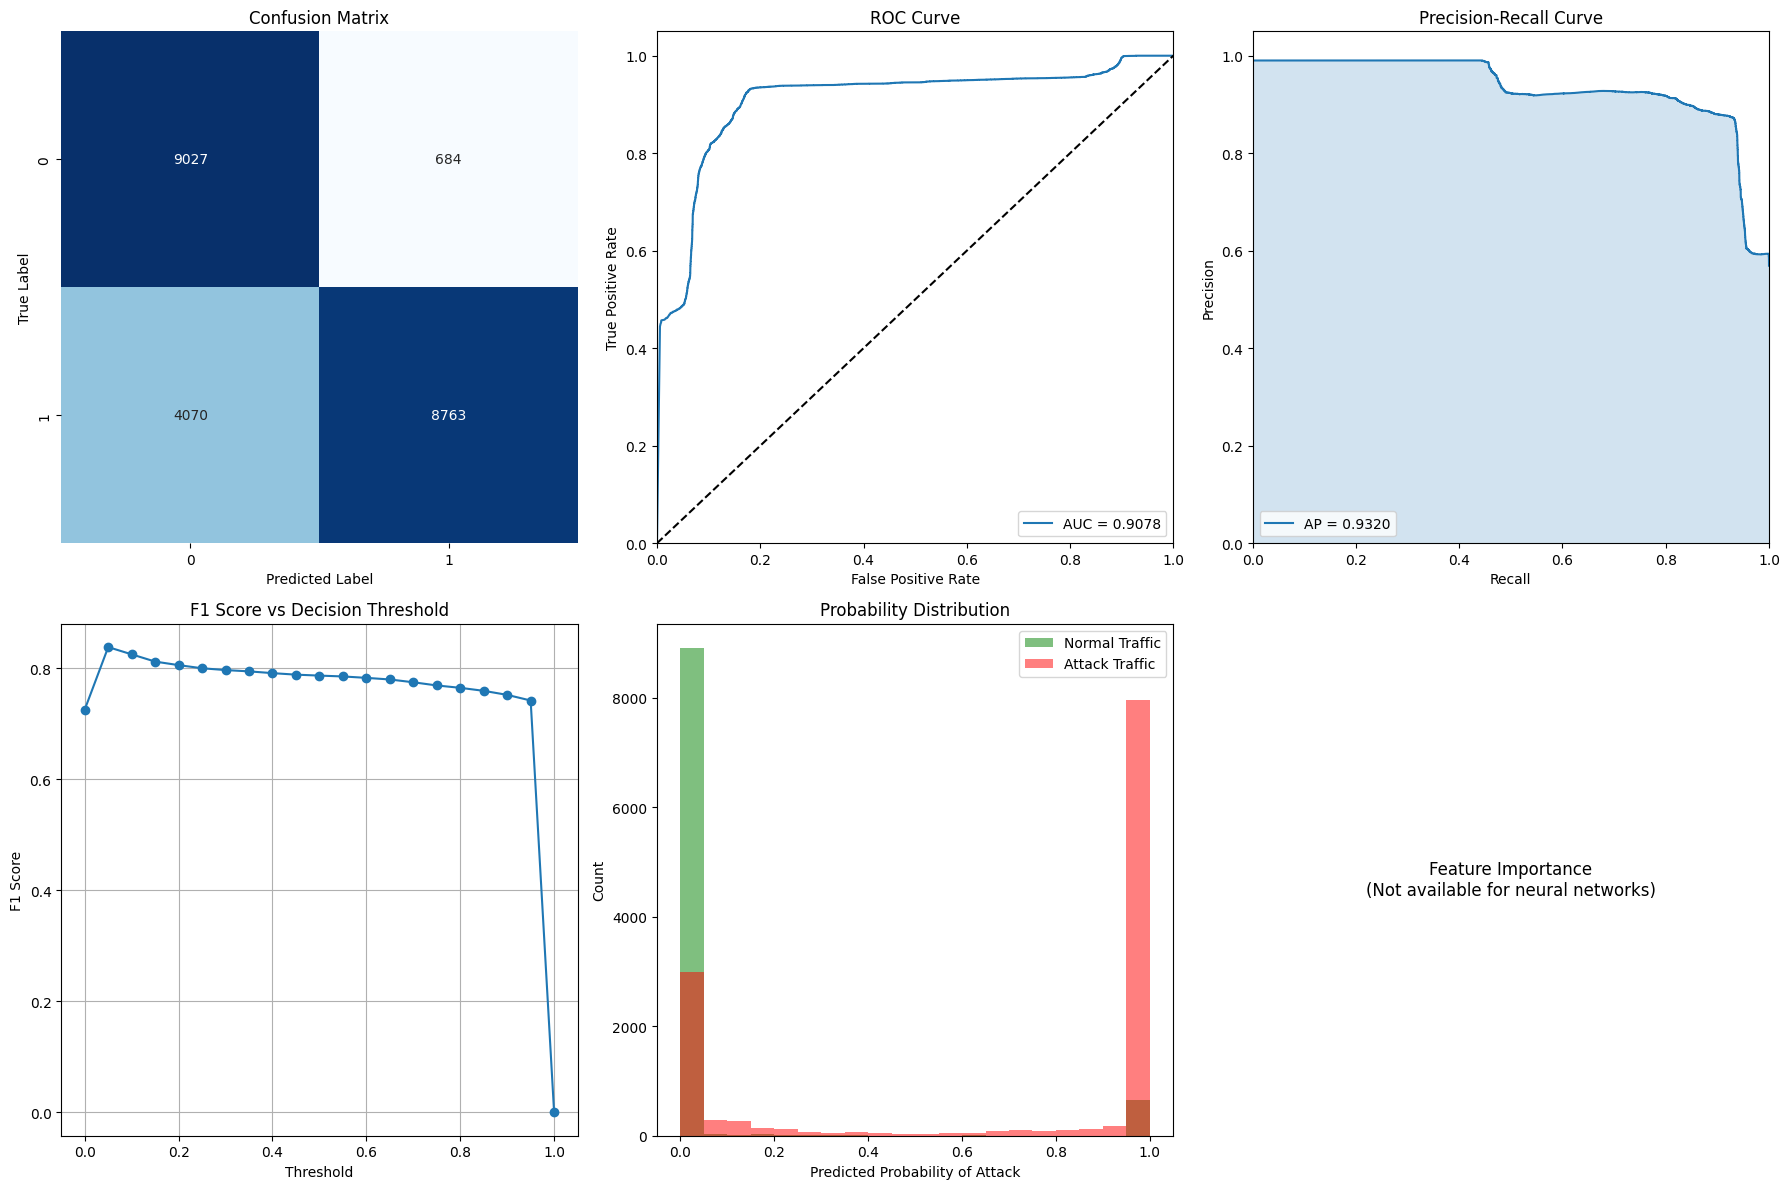


===== NIDS Model Performance Report =====
Accuracy: 0.7891
Precision: 0.9276
Recall: 0.6828
F1 Score: 0.7866
AUC-ROC: 0.9078

True Positives: 8763 (Attacks correctly identified)
False Positives: 684 (Normal traffic incorrectly flagged as attacks)
True Negatives: 9027 (Normal traffic correctly identified)
False Negatives: 4070 (Attacks missed)

False Positive Rate: 0.0704
False Negative Rate: 0.3172

Optimal decision threshold: 0.05
F1 Score at optimal threshold: 0.8379

============= End of Report =============
Report saved to 'nids_model_report.txt'
Analysis and visualization completed!


In [ ]:
def analyze_results(y_true, y_pred, y_pred_prob):
    """
    Analyze model results and create visualizations

    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    y_pred_prob : array-like
        Predicted probabilities
    """
    # Create a figure with multiple subplots
    plt.figure(figsize=(18, 12))

    # 1. Confusion Matrix
    plt.subplot(2, 3, 1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # 2. ROC Curve
    plt.subplot(2, 3, 2)
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    # 3. Precision-Recall Curve
    plt.subplot(2, 3, 3)
    from sklearn.metrics import precision_recall_curve, average_precision_score
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    ap = average_precision_score(y_true, y_pred_prob)
    plt.step(recall, precision, where='post', label=f'AP = {ap:.4f}')
    plt.fill_between(recall, precision, step='post', alpha=0.2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

    # 4. Decision Threshold Analysis
    plt.subplot(2, 3, 4)
    thresholds = np.arange(0, 1.01, 0.05)
    f1_scores = []
    for threshold in thresholds:
        y_pred_t = (y_pred_prob > threshold).astype(int)
        from sklearn.metrics import f1_score
        f1 = f1_score(y_true, y_pred_t)
        f1_scores.append(f1)

    plt.plot(thresholds, f1_scores, '-o')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs Decision Threshold')
    plt.grid(True)

    # 5. Probability Distribution
    plt.subplot(2, 3, 5)
    normal_probs = y_pred_prob[y_true == 0]
    attack_probs = y_pred_prob[y_true == 1]

    plt.hist(normal_probs, bins=20, alpha=0.5, label='Normal Traffic', color='green')
    plt.hist(attack_probs, bins=20, alpha=0.5, label='Attack Traffic', color='red')
    plt.xlabel('Predicted Probability of Attack')
    plt.ylabel('Count')
    plt.title('Probability Distribution')
    plt.legend()

    # 6. Feature Importance (if available)
    plt.subplot(2, 3, 6)
    plt.text(0.5, 0.5, "Feature Importance\n(Not available for neural networks)",
             ha='center', va='center', fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('nids_analysis_results.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Create a summary report
    print("\n===== NIDS Model Performance Report =====")

    # Basic metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")

    # Confusion matrix breakdown
    tn, fp, fn, tp = cm.ravel()
    print(f"\nTrue Positives: {tp} (Attacks correctly identified)")
    print(f"False Positives: {fp} (Normal traffic incorrectly flagged as attacks)")
    print(f"True Negatives: {tn} (Normal traffic correctly identified)")
    print(f"False Negatives: {fn} (Attacks missed)")

    # Additional metrics
    fpr = fp / (fp + tn)  # False positive rate
    fnr = fn / (tp + fn)  # False negative rate

    print(f"\nFalse Positive Rate: {fpr:.4f}")
    print(f"False Negative Rate: {fnr:.4f}")

    # Optimal threshold
    best_threshold_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_idx]
    print(f"\nOptimal decision threshold: {best_threshold:.2f}")
    print(f"F1 Score at optimal threshold: {f1_scores[best_threshold_idx]:.4f}")

    print("\n============= End of Report =============")

    # Save the report to a file
    with open('nids_model_report.txt', 'w') as f:
        f.write("===== NIDS Model Performance Report =====\n")
        f.write(f"Accuracy: {accuracy:.4f}\n")
        f.write(f"Precision: {precision:.4f}\n")
        f.write(f"Recall: {recall:.4f}\n")
        f.write(f"F1 Score: {f1:.4f}\n")
        f.write(f"AUC-ROC: {roc_auc:.4f}\n")
        f.write(f"\nTrue Positives: {tp} (Attacks correctly identified)\n")
        f.write(f"False Positives: {fp} (Normal traffic incorrectly flagged as attacks)\n")
        f.write(f"True Negatives: {tn} (Normal traffic correctly identified)\n")
        f.write(f"False Negatives: {fn} (Attacks missed)\n")
        f.write(f"\nFalse Positive Rate: {fpr:.4f}\n")
        f.write(f"False Negative Rate: {fnr:.4f}\n")
        f.write(f"\nOptimal decision threshold: {best_threshold:.2f}\n")
        f.write(f"F1 Score at optimal threshold: {f1_scores[best_threshold_idx]:.4f}\n")
        f.write("\n============= End of Report =============\n")

    print("Report saved to 'nids_model_report.txt'")

# Generate analysis and report if model has been trained
if 'X_test' in locals() and 'y_test' in locals() and 'nids_model' in locals():
    # Get predictions on test data
# Function to generate an analytical report after training the model
    def generate_analytical_report(model, X_test, y_test):
        print("Generating analytical report...")

        # Make predictions
        y_pred_prob = model.predict(X_test)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()

        # Analyze results
        analyze_results(y_test, y_pred, y_pred_prob.flatten())

        return y_pred, y_pred_prob

# Run the analysis if model has been trained
if 'X_test' in locals() and 'y_test' in locals() and 'nids_model' in locals():
    print("\nGenerating comprehensive analysis and visualization report...")
    y_pred, y_pred_prob = generate_analytical_report(nids_model, X_test, y_test)
    print("Analysis and visualization completed!")

## step 07

Let's integrate all components and provide a user-friendly interface.

In [ ]:
class NIDSSystem:
    """
    Network Intrusion Detection System - Complete Integration

    This class integrates all components of the NIDS system:
    - Data preprocessing
    - Model training
    - Real-time detection
    - Visualization and reporting
    """

    def __init__(self):
        """Initialize the NIDS system"""
        self.scaler = None
        self.model = None
        self.training_history = None
        self.dataset_loaded = False
        self.model_trained = False

    def load_dataset(self, train_path=None, test_path=None):
        """
        Load and preprocess the dataset

        Parameters:
        -----------
        train_path : str, optional
            Path to the training dataset
        test_path : str, optional
            Path to the testing dataset

        Returns:
        --------
        bool : Whether dataset loading was successful
        """
        try:
            # Download or load the dataset
            self.train_data, self.test_data = download_nsl_kdd()

            if self.train_data is None or self.test_data is None:
                print("Failed to load dataset.")
                return False

            # Preprocess the data
            self.X_train, self.y_train, self.X_test, self.y_test, self.scaler = preprocess_data(
                self.train_data, self.test_data
            )

            self.dataset_loaded = True
            print("Dataset loaded and preprocessed successfully!")
            return True

        except Exception as e:
            print(f"Error loading dataset: {e}")
            return False

    def train_model(self, save_path='nids_model.h5'):
        """
        Train the NIDS machine learning model

        Parameters:
        -----------
        save_path : str, optional
            Path to save the trained model

        Returns:
        --------
        bool : Whether model training was successful
        """
        try:
            if not self.dataset_loaded:
                print("Dataset not loaded. Please load the dataset first.")
                return False

            print("Training NIDS model...")

            # Build and train the model
            self.model = build_model(self.X_train.shape[1])

            # Define early stopping to prevent overfitting
            early_stopping = EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            )

            # Train the model
            self.training_history = self.model.fit(
                self.X_train, self.y_train,
                epochs=20,  # Reduced for faster training
                batch_size=128,
                validation_split=0.2,
                callbacks=[early_stopping],
                verbose=1
            )

            # Save the model
            self.model.save(save_path)
            print(f"Model saved to {save_path}")

            # Evaluate the model
            test_loss, test_accuracy = self.model.evaluate(self.X_test, self.y_test)
            print(f"Test Accuracy: {test_accuracy:.4f}")

            self.model_trained = True
            return True

        except Exception as e:
            print(f"Error training model: {e}")
            return False

    def evaluate_model(self):
        """
        Evaluate the trained model and generate reports

        Returns:
        --------
        bool : Whether evaluation was successful
        """
        try:
            if not self.model_trained:
                print("Model not trained. Please train the model first.")
                return False

            # Make predictions
            y_pred_prob = self.model.predict(self.X_test)
            y_pred = (y_pred_prob > 0.5).astype(int).flatten()

            # Display classification report
            print("\nClassification Report:")
            print(classification_report(self.y_test, y_pred))

            # Generate comprehensive analysis
            analyze_results(self.y_test, y_pred, y_pred_prob.flatten())

            return True

        except Exception as e:
            print(f"Error evaluating model: {e}")
            return False

    def start_real_time_detection(self, interface=None, timeout=60):
        """
        Start real-time network traffic monitoring and intrusion detection

        Parameters:
        -----------
        interface : str, optional
            Network interface to monitor
        timeout : int, optional
            Timeout in seconds for packet capture

        Returns:
        --------
        bool : Whether real-time detection was started successfully
        """
        try:
            if not self.model_trained:
                print("Model not trained. Please train the model first.")
                return False

            # Determine network interface if not specified
            if interface is None:
                try:
                    import netifaces
                    interfaces = netifaces.interfaces()
                    # Remove loopback interfaces
                    interfaces = [i for i in interfaces if not i.startswith('lo')]

                    if not interfaces:
                        print("No network interfaces found!")
                        return False

                    interface = interfaces[0]
                    print(f"Available interfaces: {interfaces}")
                    print(f"Using interface: {interface}")
                except ImportError:
                    print("Could not import netifaces. Please install it with: pip install netifaces")
                    print("Defaulting to 'eth0' interface.")
                    interface = 'eth0'

            # Create and start the NIDS
            nids = NIDSPacketCapture(
                model_path='nids_model.h5',
                scaler=self.scaler,
                interface=interface
            )

            # Start the capture
            nids.start_capture(timeout=timeout)
            return True

        except Exception as e:
            print(f"Error starting real-time detection: {e}")
            return False

    def run(self):
        """
        Run the complete NIDS pipeline with user interaction
        """
        print("=" * 80)
        print("Network Intrusion Detection System (NIDS) using Machine Learning")
        print("=" * 80)

        # Step 1: Load dataset
        print("\nStep 1: Loading dataset...")
        if not self.load_dataset():
            print("Failed to load dataset. Exiting.")
            return

        # Step 2: Train model
        print("\nStep 2: Training model...")
        if not self.train_model():
            print("Failed to train model. Exiting.")
            return

        # Step 3: Evaluate model
        print("\nStep 3: Evaluating model...")
        if not self.evaluate_model():
            print("Failed to evaluate model. Continuing anyway.")

        # Step 4: Real-time detection
        print("\nStep 4: Starting real-time detection...")
        print("NOTE: This step requires administrator/root privileges in a real environment.")
        print("In a Jupyter notebook, packet capture functionality might be limited.")

        try:
            user_input = input("Do you want to proceed with real-time detection? (y/n): ")
            if user_input.lower() == 'y':
                timeout = 60
                try:
                    timeout_input = input("Enter capture duration in seconds (default: 60): ")
                    if timeout_input.strip():
                        timeout = int(timeout_input)
                except ValueError:
                    print("Invalid input. Using default timeout of 60 seconds.")

                self.start_real_time_detection(timeout=timeout)
            else:
                print("Skipping real-time detection.")
        except Exception as e:
            print(f"Error during user interaction: {e}")

        print("\nNIDS pipeline completed!")

# Function to run the complete NIDS system
def run_complete_nids():
    """
    Run the complete NIDS system pipeline
    """
    nids_system = NIDSSystem()
    nids_system.run()

# Provide guidance on how to run the system
print("\n" + "=" * 80)
print("NIDS Project Implementation Complete!")
print("=" * 80)
print("\nTo run the complete NIDS pipeline, execute the following command:")
print("run_complete_nids()")
print("\nAlternatively, you can run individual components as follows:")
print("1. Load and preprocess data:")
print("   nids = NIDSSystem()")
print("   nids.load_dataset()")
print("\n2. Train the model:")
print("   nids.train_model()")
print("\n3. Evaluate the model:")
print("   nids.evaluate_model()")
print("\n4. Start real-time detection:")
print("   nids.start_real_time_detection()")
print("\nNote: For real-time packet capture, you may need to run the script outside")
print("of Jupyter notebook with administrator/root privileges.")


NIDS Project Implementation Complete!

To run the complete NIDS pipeline, execute the following command:
run_complete_nids()

Alternatively, you can run individual components as follows:
1. Load and preprocess data:
   nids = NIDSSystem()
   nids.load_dataset()

2. Train the model:
   nids.train_model()

3. Evaluate the model:
   nids.evaluate_model()

4. Start real-time detection:
   nids.start_real_time_detection()

Note: For real-time packet capture, you may need to run the script outside
of Jupyter notebook with administrator/root privileges.


Network Intrusion Detection System (NIDS) using Machine Learning

Step 1: Loading dataset...
Local dataset files not found. Downloading from online source...
Dataset downloaded successfully!
Dataset loaded and preprocessed successfully!

Step 2: Training model...
Training NIDS model...
Epoch 1/20
788/788 [==============================] - 4s 3ms/step - loss: 0.1268 - accuracy: 0.9599 - val_loss: 0.0485 - val_accuracy: 0.9812
Epoch 2/20
788/788 [==============================] - 3s 3ms/step - loss: 0.0563 - accuracy: 0.9794 - val_loss: 0.0325 - val_accuracy: 0.9897
Epoch 3/20
788/788 [==============================] - 2s 3ms/step - loss: 0.0415 - accuracy: 0.9870 - val_loss: 0.0258 - val_accuracy: 0.9916
Epoch 4/20
788/788 [==============================] - 2s 3ms/step - loss: 0.0334 - accuracy: 0.9889 - val_loss: 0.0242 - val_accuracy: 0.9920
Epoch 5/20
788/788 [==============================] - 2s 3ms/step - loss: 0.0290 - accuracy: 0.9902 - val_loss: 0.0216 - val_accuracy: 0.9926
Epo

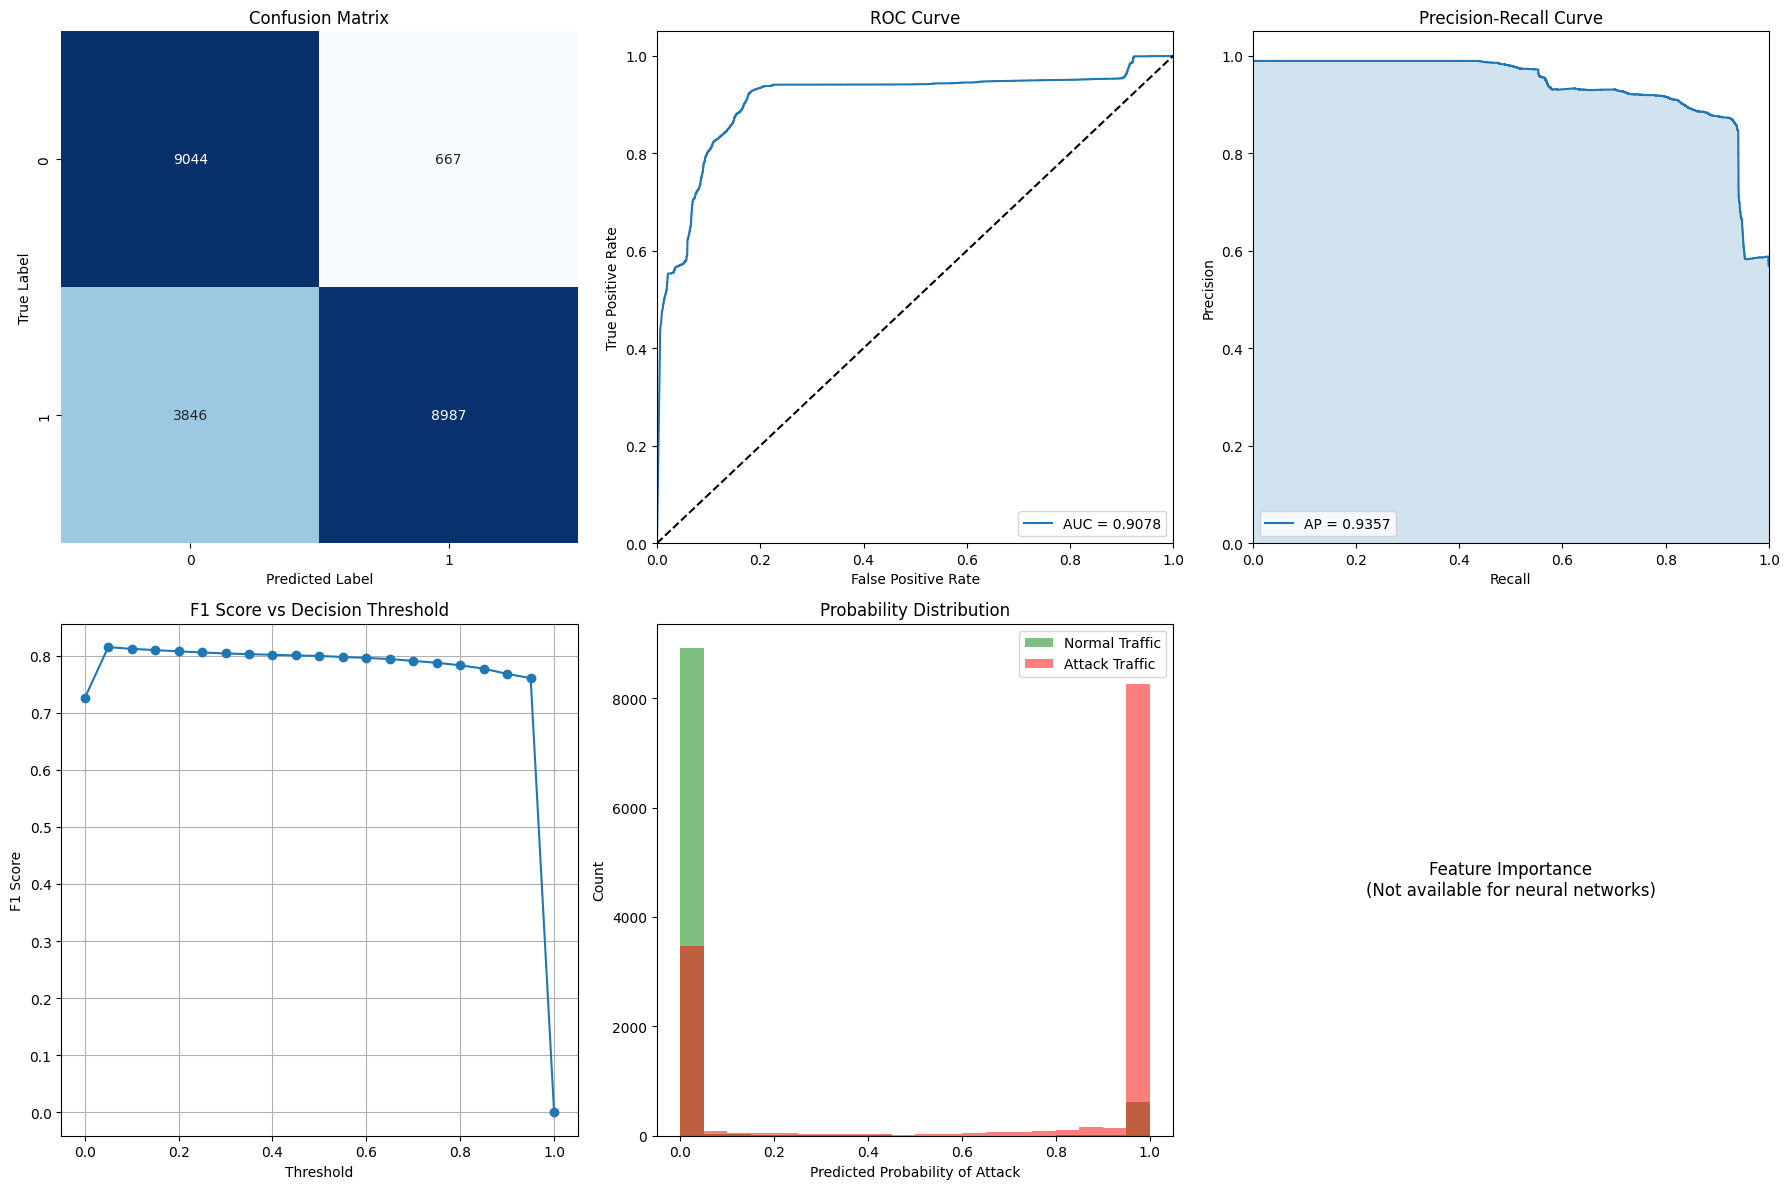


===== NIDS Model Performance Report =====
Accuracy: 0.7998
Precision: 0.9309
Recall: 0.7003
F1 Score: 0.7993
AUC-ROC: 0.9078

True Positives: 8987 (Attacks correctly identified)
False Positives: 667 (Normal traffic incorrectly flagged as attacks)
True Negatives: 9044 (Normal traffic correctly identified)
False Negatives: 3846 (Attacks missed)

False Positive Rate: 0.0687
False Negative Rate: 0.2997

Optimal decision threshold: 0.05
F1 Score at optimal threshold: 0.8148

============= End of Report =============
Report saved to 'nids_model_report.txt'

Step 4: Starting real-time detection...
NOTE: This step requires administrator/root privileges in a real environment.
In a Jupyter notebook, packet capture functionality might be limited.
Do you want to proceed with real-time detection? (y/n): n
Skipping real-time detection.

NIDS pipeline completed!


In [ ]:
run_complete_nids()